# S.E.B Data Science Project

## Import Librairies

In [165]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime
from collections import Counter
from scipy.spatial import distance
from sklearn.cluster import KMeans
from scipy.stats import linregress
from statsmodels.tsa.api import Holt
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from statsmodels.formula.api import ols
from tensorflow.keras.layers import Dense
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [166]:
warnings.simplefilter(action='ignore', category=FutureWarning)

## Constants Definition

In [167]:
SHIFT = 4
COUNTRY = 'france'
PERIOD = 'quarterly'

MILLION = 1000000
THOUSANDS = 1000

COLORS = ['#60CD18', '#0092E1', '#1A1A1A']

## Utils

In [168]:
def kl_divergence(mean1, var1, mean2, var2):
    return np.log(var2 / var1) + (var1 + (mean1 - mean2) ** 2) / (2 * var2) - 0.5

def kl_divergence_normal(df_col):
    kl_divergences = []

    for i in range(SHIFT, len(df_col) - SHIFT):
        dist1 = df_col.iloc[i-SHIFT:i+1]
        dist2 = df_col.iloc[i:i+SHIFT]

        mean1, var1 = np.mean(dist1), np.var(dist1)
        mean2, var2 = np.mean(dist2), np.var(dist2)

        kl_divergences.append(kl_divergence(mean1, var1, mean2, var2))

    mean_div = sum(kl_divergences) / len(kl_divergences)
    for i in range(SHIFT):
        kl_divergences.insert(0, mean_div)
        kl_divergences.append(mean_div)
    
    return kl_divergences

def convert_to_datetime(quarter_str):
    year, quarter = quarter_str.split('-')
    year = int(year)
    quarter_to_month = {'Q1': 2, 'Q2': 5, 'Q3': 8, 'Q4': 11}
    month = quarter_to_month.get(quarter)
    result_date = datetime(year, month, 1)
    return result_date

def transform_to_datetime(values):
    return [convert_to_datetime(val) for val in values]

def knn_classification(data_points, point_to_classify, k):
    distances = [(label, distance.euclidean(coords, point_to_classify)) for label, coords, value in data_points]
    sorted_distances = sorted(distances, key=lambda x: x[1])
    nearest_neighbors = sorted_distances[:k]
    nearest_labels = [label for label, dist in nearest_neighbors]
    most_common_label = Counter(nearest_labels).most_common(1)[0][0]
    return most_common_label

## Load Data

In [169]:
data = pd.read_csv(f'data/{COUNTRY}_aggregates/{COUNTRY}_{PERIOD}.csv')
behavior_data = data[data['quantify'] == 'behavior']
state_data = data[data['quantify'] == 'state']

## Behavior EDA

### Transformation

In [170]:
df_behavior = behavior_data.T
df_header = df_behavior.iloc[0].to_list()
df_behavior.columns = df_header
df_behavior = df_behavior.drop(df_behavior.index[0])
df_behavior.index.name = None
df_behavior = df_behavior.drop(index=['quantify', 'unit', 'information', 'category'])

In [171]:
nb_households = data[data['index'] == 'number of households'].T
nb_houseolhds_header = nb_households.iloc[0].to_list()
nb_households.columns = nb_houseolhds_header
nb_households = nb_households.drop(nb_households.index[0])
nb_households = nb_households.drop(index=['quantify', 'unit', 'information', 'category'])

In [172]:
df_behavior['total_durability_expenditure'] = df_behavior.iloc[:, 2:6].sum(axis=1)
df_behavior['total_coicop_expenditure'] = df_behavior.iloc[:, 6:118].sum(axis=1)
df_behavior['total_assets_cat'] = df_behavior.iloc[:, 25:31].sum(axis=1)
df_behavior['total_liabilities_cat'] = df_behavior.iloc[:, 31:33].sum(axis=1)

### Features Engineering

In [173]:
df_per_household = pd.DataFrame()
df_per_household['bop'] = (df_behavior['balance of payment'] * MILLION) / (nb_households['number of households'] * THOUSANDS)
df_per_household['final expenditure'] = (df_behavior['final expenditure of households'] * MILLION) / (nb_households['number of households'] * THOUSANDS)
df_per_household['ratio expenditure for durable goods'] = df_behavior['expenditure of households for durable goods'] / df_behavior['total_durability_expenditure'] * 100
df_per_household['ratio expenditure for semi-durable goods'] = df_behavior['expenditure of households for semi-durable goods'] / df_behavior['total_durability_expenditure'] * 100
df_per_household['ratio expenditure for non-durable goods'] = df_behavior['expenditure of households for non-durable goods'] / df_behavior['total_durability_expenditure'] * 100
df_per_household['ratio expenditure for services'] = df_behavior['expenditure of households for services'] / df_behavior['total_durability_expenditure'] * 100
df_per_household['ratio expenditure for housing, water, electricity, gas and other fuels'] =  df_behavior['housing, water, electricity, gas and other fuels'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for food and non-alcoholic beverages'] = df_behavior['food and non-alcoholic beverages'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for transports'] = df_behavior['transport'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for miscellaneous goods and services'] = df_behavior['miscellaneous goods and services'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for recreation and culture'] = df_behavior['recreation and culture'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for furnishings, household equipment, maintenance'] = df_behavior['furnishings, household equipment, maintenance'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for restaurants and hotels'] = df_behavior['restaurants and hotels'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for clothing and footwear'] = df_behavior['clothing and footwear'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for health'] = df_behavior['health'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for communications'] = df_behavior['communications'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for alcoholic beverages, tobacco and narcotics'] = df_behavior['alcoholic beverages, tobacco and narcotics'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['ratio expenditure for education'] = df_behavior['education'] / df_behavior['total_coicop_expenditure'] * 100
df_per_household['composite significant purcahse intention'] = df_behavior[['intention to buy a car within the next 12 months', 'purchase or build a home within the next 12 months', 'home improvements over the next 12 months']].apply(lambda x: (x - x.mean()) / x.std()).mean(axis=1)
df_per_household['normalized significant purcahse intention'] = (df_per_household['composite significant purcahse intention'] - df_per_household['composite significant purcahse intention'].min()) / (df_per_household['composite significant purcahse intention'].max() - df_per_household['composite significant purcahse intention'].min()) * 100
df_per_household['saving rate'] = df_behavior['gross household saving rate']
df_per_household['investment rate'] = df_behavior['gross household investment rate']
df_per_household['inability to face unexpected expenses'] = df_behavior['inability to face unexpected financial expenses']
df_per_household['ratio currency and deposits assets'] = df_behavior['currency and deposits assets'] / df_behavior['total_assets_cat'] * 100
df_per_household['ratio debts securities assets'] = df_behavior['debts securities assets'] / df_behavior['total_assets_cat'] * 100
df_per_household['ratio loans assets'] = df_behavior['loans assets'] / df_behavior['total_assets_cat'] * 100
df_per_household['ratio equity and investment fund shares assets'] = df_behavior['equity and investment fund shares assets'] / df_behavior['total_assets_cat'] * 100
df_per_household['ratio insurance, pensions, guarantees assets'] = df_behavior['insurance, pensions, guarantees assets'] / df_behavior['total_assets_cat'] * 100
df_per_household['ratio other accounts receivable / payable assets'] = df_behavior['other accounts receivable / payable assets'] / df_behavior['total_assets_cat'] * 100
df_per_household['ratio loans liabilities'] = df_behavior['loans liabilities'] / df_behavior['total_liabilities_cat'] * 100
df_per_household['ratio other accounts receivable / payable liabilities'] = df_behavior['other accounts receivable / payable liabilities'] / df_behavior['total_liabilities_cat'] * 100
df_per_household['total assets variations'] = df_behavior['total assets'].diff()
df_per_household['total liabilities variations'] = df_behavior['total liabilities'].diff()
df_per_household['net savings'] = df_per_household['total assets variations'] - df_per_household['total liabilities variations']

df_per_household.fillna(0, inplace=True)
df_per_household = df_per_household.drop(columns=['composite significant purcahse intention', 'total assets variations', 'total liabilities variations'])

### Kullback-Leibler Divergence

KL divergence measures how one probability distribution diverges from a second, expected probability distribution. It is used to quantify the difference between the actual data distribution and a reference distribution (usually normal or expected behavior). Higher values of KL divergence indicate greater deviation from the expected distribution, signaling potential anomalies.

In [174]:
df_per_household['cum_kld'] = 0
for col in df_per_household.columns:
    if col != 'cum_kld':
        df_per_household['cum_kld'] += kl_divergence_normal(df_per_household[col])

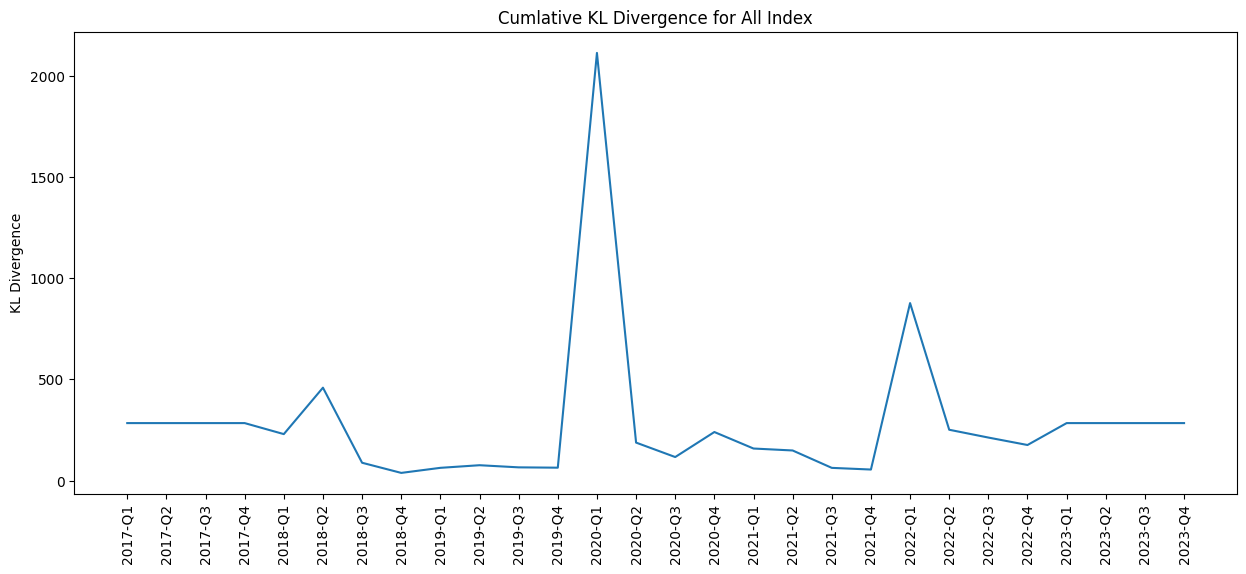

In [175]:
plt.figure(figsize=(15, 6))
plt.plot(df_per_household.index, df_per_household['cum_kld'])
plt.title("Cumlative KL Divergence for All Index")
plt.xticks(rotation=90)
plt.ylabel('KL Divergence')
plt.show()

### Isolation Forest

Isolation Forest is an ensemble learning methods that isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The anomaly score indicates the likelihood of a point being an outlier. Scores are higher for points that are easier to isolate (outliers) and lower for points that are harder to isolate (inliers).

In [176]:
df_per_household['cum_anomaly_score'] = 0
for col in df_per_household.columns:
    if col != 'cum_kld':
        behavior_anomaly = IsolationForest(n_estimators=50)
        behavior_anomaly.fit(df_per_household[[col]])
        df_per_household['cum_anomaly_score'] += behavior_anomaly.decision_function(df_per_household[[col]])

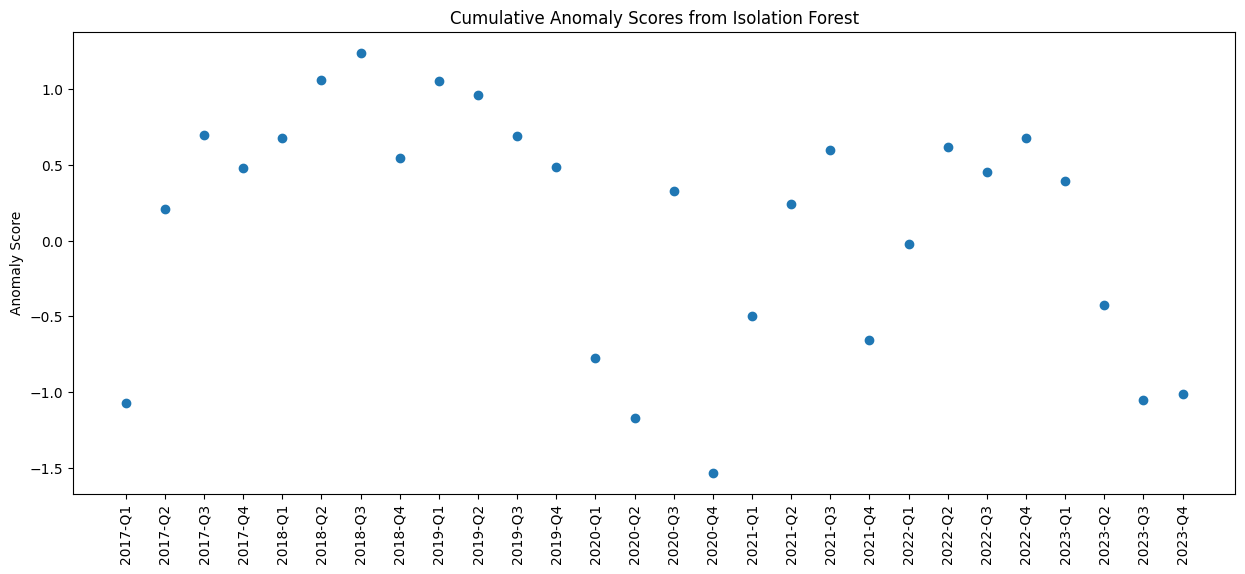

In [177]:
plt.figure(figsize=(15, 6))
plt.scatter(df_per_household.index, df_per_household['cum_anomaly_score'])
plt.title('Cumulative Anomaly Scores from Isolation Forest')
plt.xticks(rotation=90)
plt.ylabel('Anomaly Score')
plt.show()

### Anomaly Combination

Applying the exponential function to the anomaly scores amplifies the differences. This is particularly useful because small differences in anomaly scores can become more pronounced, making significant anomalies stand out more. By multiplying the exponential anomaly scores with KL divergence values, we effectively weight the anomalies detected by Isolation Forest with the severity of the divergence from the expected distribution. This creates a composite score that captures both the isolation-based and distribution-based anomalies. The new formulation leverages the strengths of both methods. The exponential function enhances the sensitivity of the anomaly scores, while the multiplication with KL divergence ensures that significant distributional deviations are given appropriate weight. The exponential transformation makes the approach more sensitive to the severity of anomalies. Minor anomalies are less amplified, whereas significant anomalies are emphasized. The exponential transformation makes the approach more sensitive to the severity of anomalies. Minor anomalies are less amplified, whereas significant anomalies are emphasized.

In [178]:
spline = interp1d([i for i in range(len(df_per_household.index))], np.exp(-df_per_household['cum_anomaly_score']) * df_per_household['cum_kld'], kind='cubic')

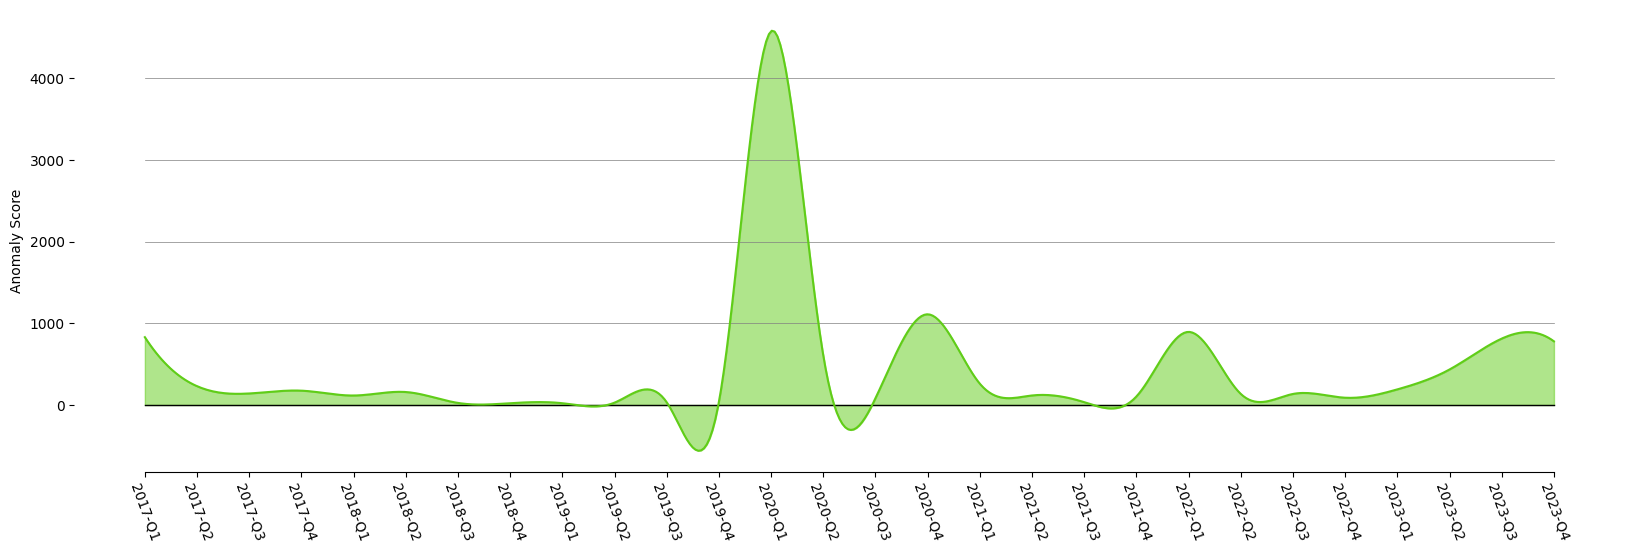

In [179]:
tick_locations = np.linspace(0, 27, len(df_per_household.index))

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot([0, 27],[0, 0], color="black", linewidth=1)
ax.plot([0, 27],[1000, 1000], color="gray", linewidth=0.5)
ax.plot([0, 27],[2000, 2000], color="gray", linewidth=0.5)
ax.plot([0, 27],[3000, 3000], color="gray", linewidth=0.5)
ax.plot([0, 27],[4000, 4000], color="gray", linewidth=0.5)
ax.plot(np.linspace(0, 27, 500), spline(np.linspace(0, 27, 500)), color='#60CD18')
ax.fill_between(np.linspace(0, 27, 500), spline(np.linspace(0, 27, 500)), color='#60CD18', alpha=0.5)

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(0, 27)

ax.set_xticks(tick_locations, df_per_household.index, rotation=-70)
ax.set_ylabel('Anomaly Score')

plt.savefig("great.png", dpi=300)

plt.show()

## Behavior Analysis

### Normalization

In [180]:
norm_behavior = StandardScaler().fit_transform(df_per_household)

### PCA

In [181]:
pca_behavior = PCA(n_components=2)
behavior_component = pca_behavior.fit_transform(norm_behavior)

### Clustering

In [182]:
n = 3 # Because Intuition Insights
behavior_cluster = KMeans(n_clusters=n).fit(behavior_component)

In [183]:
labeled_centroids = {}
for i in range(n):
    labeled_centroids[i] = list(behavior_cluster.cluster_centers_[i])

In [184]:
res = {label: {'x': [], 'y': [], 'values': []} for label in range(n)}
points = behavior_component.tolist()
for i in range(len(points)):
    res[behavior_cluster.labels_[i]]['x'].append(points[i][0])
    res[behavior_cluster.labels_[i]]['y'].append(points[i][1])
    res[behavior_cluster.labels_[i]]['values'].append(df_behavior.index.to_list()[i])

In [185]:
clusters = []
for index in df_per_household.index:
    for cluster in res.keys():
        if index in res[cluster]['values']:
            clusters.append(cluster)

df_per_household['cluster'] = clusters

### Visualize

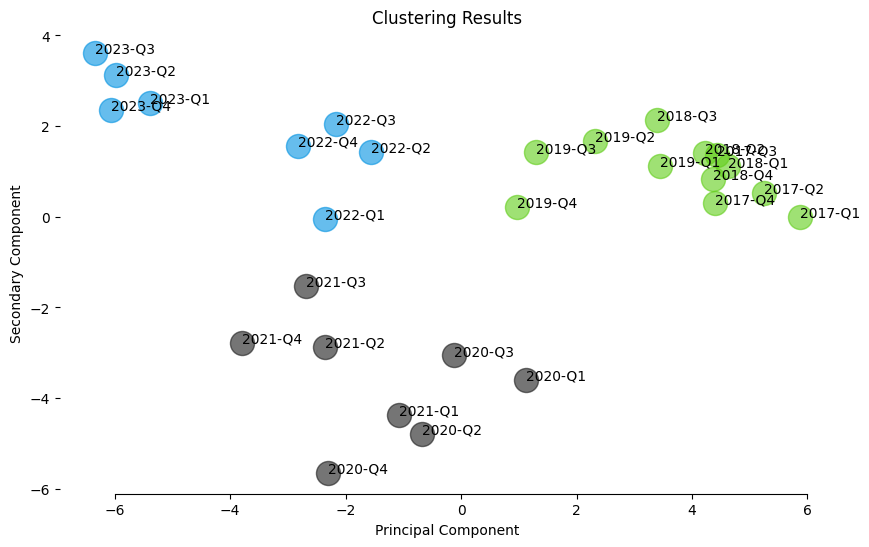

In [186]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Clustering Results")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Secondary Component")

for cluster in res:
    X, Y, labels = res[cluster]['x'], res[cluster]['y'], res[cluster]['values']
    ax.scatter(X, Y, c=COLORS[cluster], s=300, alpha=0.6)
    for i, label in enumerate(labels):
        ax.annotate(label, (X[i], Y[i]))

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(-6, 6)

plt.show()

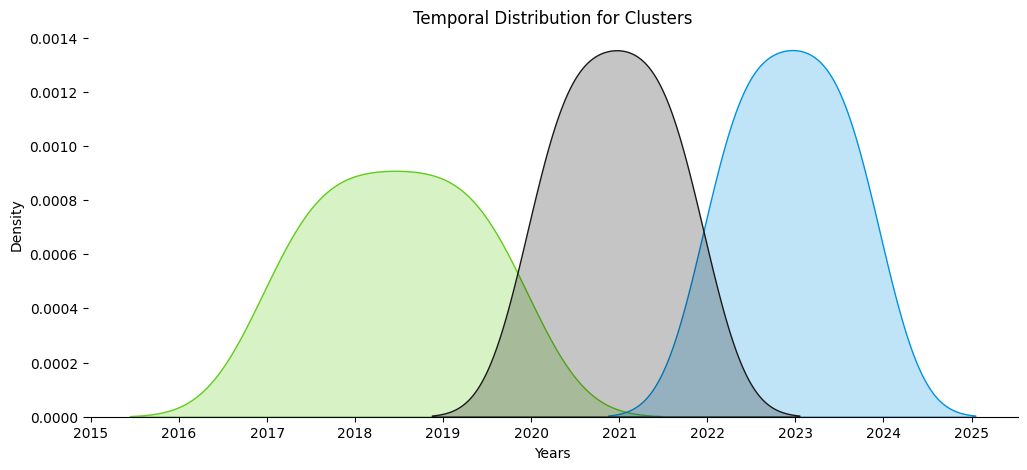

In [187]:
data = [transform_to_datetime(res[label]['values']) for label in res]
labels = [label for label in res]

fig, ax = plt.subplots(figsize=(12, 5))
ax.set_title('Temporal Distribution for Clusters')
ax.set_xlabel("Years")
ax.set_ylabel("Density")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

for i, cluster_data in enumerate(data):
    sns.kdeplot(cluster_data, fill=True, label=labels[i], color=COLORS[i])

plt.show()

### Get Detected Periods

In [188]:
periods = df_per_household.groupby('cluster')
cluster_edges = {cluster: [group.index[0], group.index[-1]] for cluster, group in periods}
print("Detected Periods :", cluster_edges)

Detected Periods : {0: ['2017-Q1', '2019-Q4'], 1: ['2022-Q1', '2023-Q4'], 2: ['2020-Q1', '2021-Q4']}


### ANOVA

ANOVA (Analysis of Variance) is a statistical method used to compare the means of three or more groups to determine if there are significant differences among them. It tests the null hypothesis that all group means are equal against the alternative that at least one is different. However, ANOVA alone does not specify which groups differ from each other. The Tukey test, also known as Tukey's Honest Significant Difference (HSD) test, is a post-hoc analysis conducted after ANOVA. It allows for pairwise comparisons between group means to identify specifically which groups are significantly different from each other. Together, ANOVA coupled with a Tukey test enables us to:
- Determine if there are overall differences among group means.
- Identify which specific groups have significant differences between their means.

This combination provides a comprehensive analysis of group differences in the data.

In [189]:
anova_behavior = df_per_household.copy() #Prepare DataFrame
anova_behavior.columns = anova_behavior.columns.str.replace(' ', '')
anova_behavior.columns = anova_behavior.columns.str.replace(',', '')
anova_behavior.columns = anova_behavior.columns.str.replace('/', '')
anova_behavior.columns = anova_behavior.columns.str.replace('-', '')
anova_behavior['cluster'] = anova_behavior['cluster'].astype('category')

indexes = anova_behavior.columns.difference(['cluster', 'cum_kld', 'cum_anomaly_score'])

for index in indexes:
    anova_behavior[index] = pd.to_numeric(anova_behavior[index])

In [190]:
anova_results = {} #Get Significant Index
significant_indexes = []

for index in indexes:
    model = ols(f'{index} ~ C(cluster)', data=anova_behavior).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    if anova_table['PR(>F)'][0] < 0.05:
        tukey = pairwise_tukeyhsd(endog=anova_behavior[index], groups=anova_behavior['cluster'], alpha=0.05)
        if np.count_nonzero(tukey.reject) >= 3:
            significant_indexes.append(index)

C:\Users\axel0\AppData\Local\Temp\ipykernel_22308\381158019.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


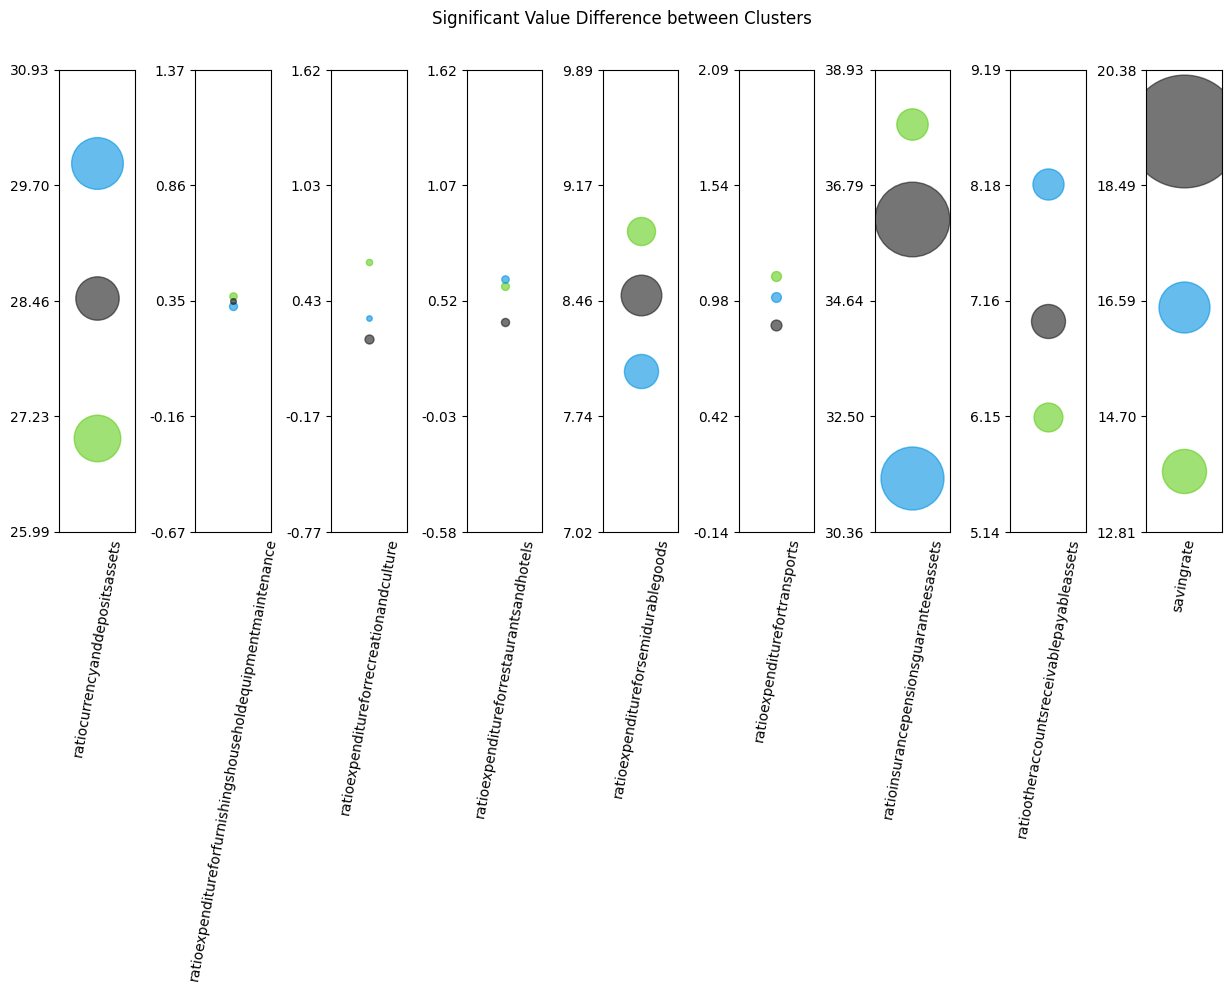

In [191]:
fig = plt.figure(figsize=(15, 6))
fig.suptitle("Significant Value Difference between Clusters")
gs = gridspec.GridSpec(1, len(significant_indexes), wspace=0.8)

mean_groups = anova_behavior.groupby('cluster').mean()
std_groups = anova_behavior.groupby('cluster').std()

# Plot each index in its own subplot
for idx, index in enumerate(significant_indexes):
    ax = fig.add_subplot(gs[idx])
    for cluster_idx in range(len(mean_groups)):
        y_value = mean_groups.loc[mean_groups.index[cluster_idx], index]
        y_std = std_groups.loc[std_groups.index[cluster_idx], index]
        ax.scatter(0, y_value, s=y_std * 2000, c=COLORS[cluster_idx], alpha=0.6)

    y_values = mean_groups.loc[:, index]
    y_ticks = np.linspace(min(y_values) - 1, max(y_values) + 1, 5)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f'{tick:.2f}' for tick in y_ticks])

    ax.set_xticks([])
    ax.set_xlabel(index, rotation=80)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Country State EDA

### Transformation

In [192]:
df_state = state_data.T
df_header = df_state.iloc[0].to_list()
df_state.columns = df_header
df_state = df_state.drop(df_state.index[0])
df_state.index.name = None
df_state = df_state.drop(index=['quantify', 'unit', 'information', 'category'], columns=['number of households', 'hicp'])

### Visualize

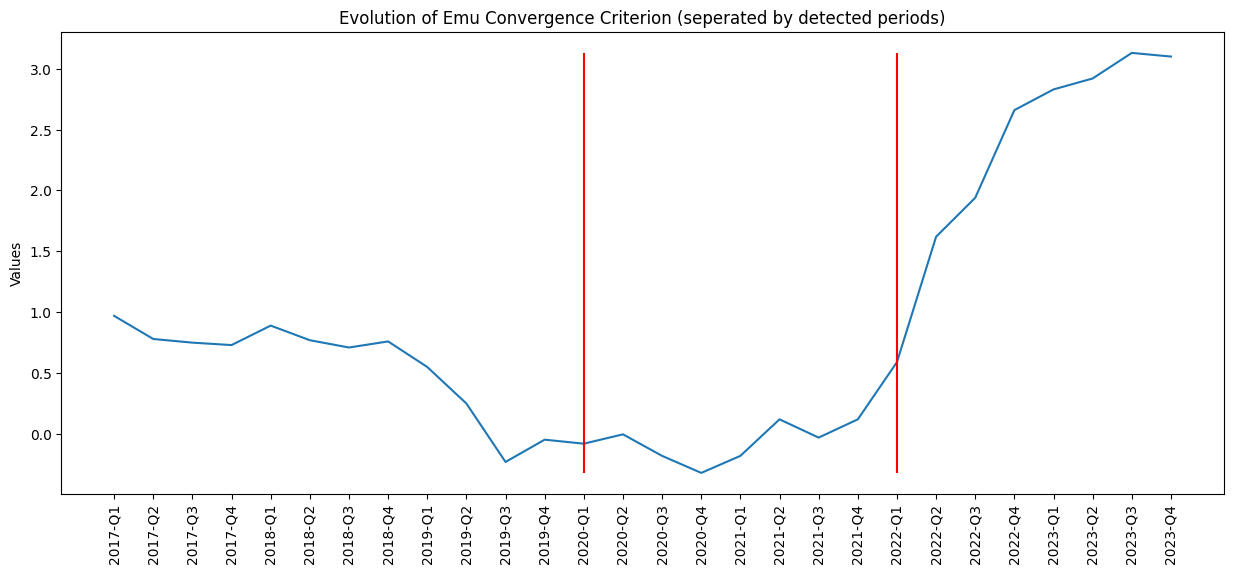

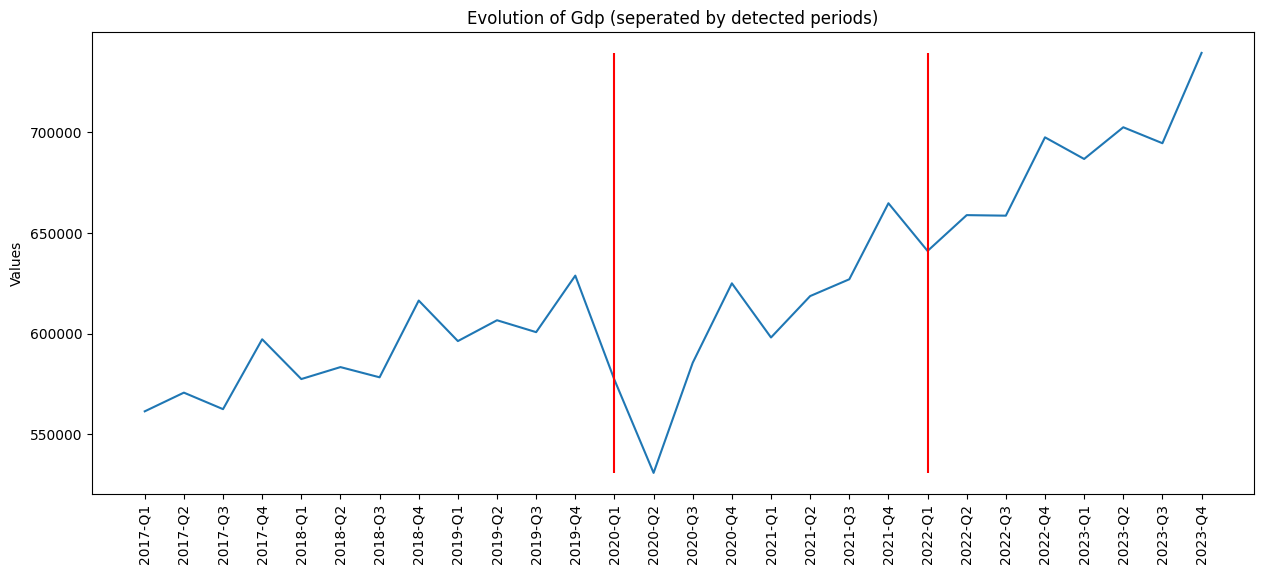

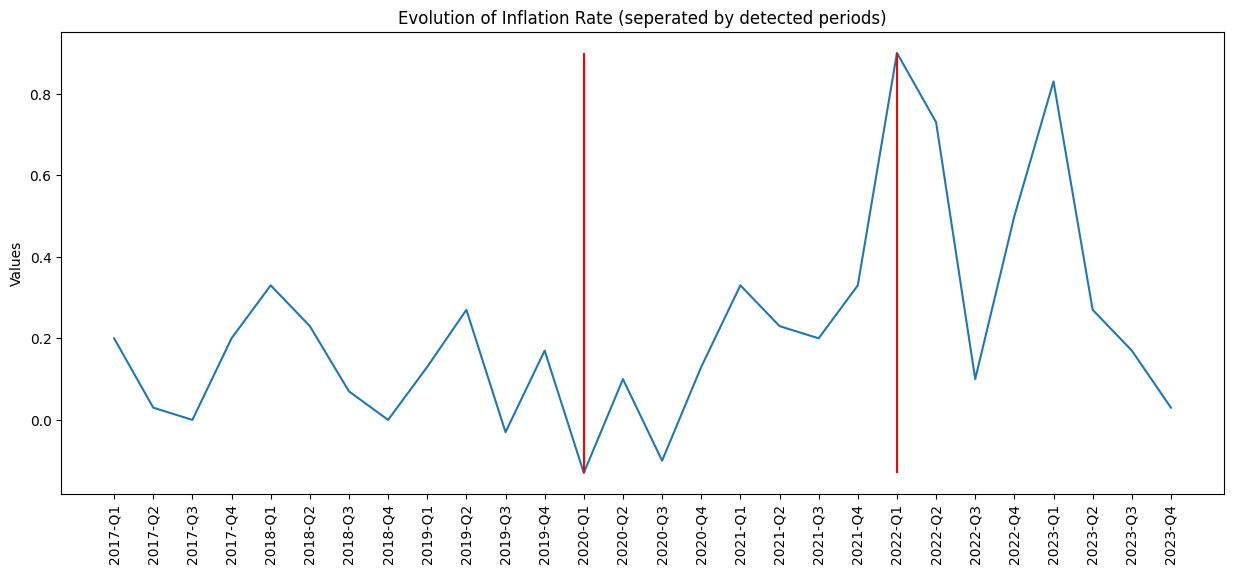

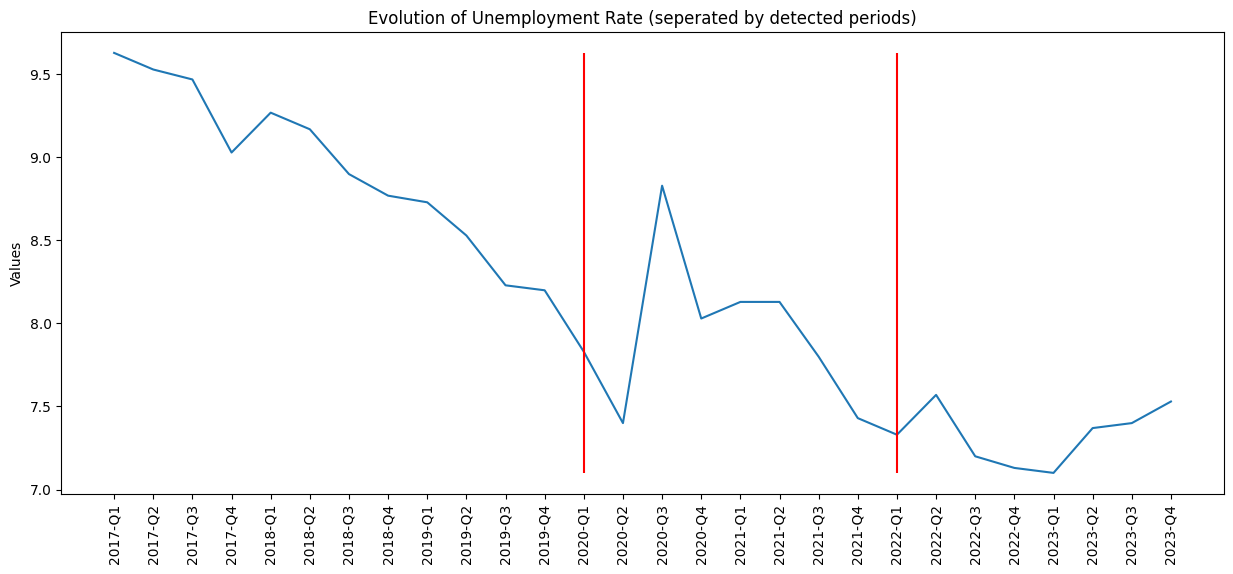

In [193]:
for col in df_state.columns:
    plt.figure(figsize=(15, 6))
    plt.title(f'Evolution of {col.title()} (seperated by detected periods)')
    plt.plot(df_state.index, df_state[col])
    plt.vlines(x = '2022-Q1', ymin=df_state[col].min(), ymax=df_state[col].max(), colors='red')
    plt.vlines(x = '2020-Q1', ymin=df_state[col].min(), ymax=df_state[col].max(), colors='red')
    plt.xticks(rotation=90)
    plt.ylabel('Values')
    plt.show()

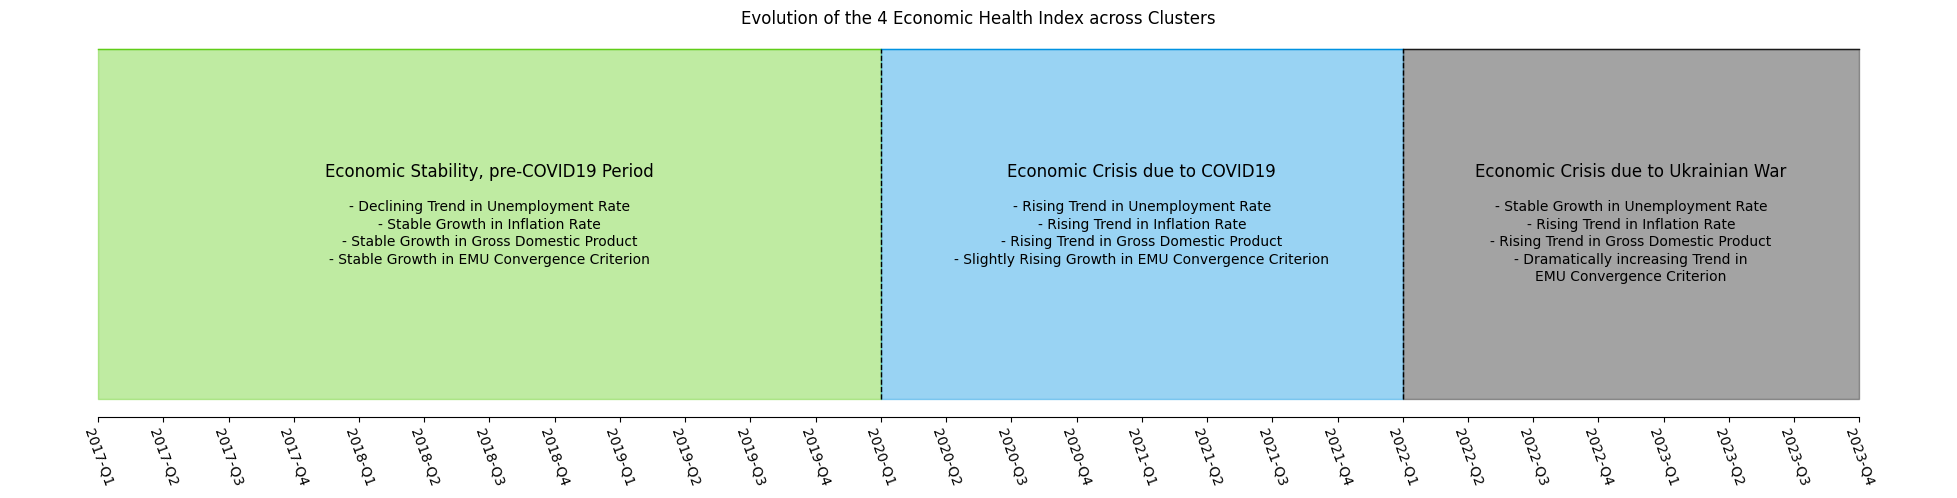

In [319]:
tick_locations = np.linspace(0, 27, len(df_per_household.index))

fig, ax = plt.subplots(figsize=(25, 5))

ax.plot([0, 12],[100, 100], color=COLORS[0], linewidth=1)
ax.plot([12, 20],[100, 100], color=COLORS[1], linewidth=1)
ax.plot([20, 27],[100, 100], color=COLORS[2], linewidth=1)

ax.fill_between([0, 12], [100, 100], color=COLORS[0], alpha=0.4)
ax.fill_between([12, 20], [100, 100], color=COLORS[1], alpha=0.4)
ax.fill_between([20, 27], [100, 100], color=COLORS[2], alpha=0.4)

ax.plot([12, 12],[0, 100], color='black', linewidth=1, linestyle='--')
ax.plot([20, 20],[0, 100], color='black', linewidth=1, linestyle='--')

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(0, 27)

ax.set_xticks(tick_locations, df_per_household.index, rotation=-70)
ax.set_yticks([])
ax.set_yticklabels([]) 

ax.text(6, 65, 'Economic Stability, pre-COVID19 Period', ha='center', va='center', fontsize=12)
ax.text(6, 55, '- Declining Trend in Unemployment Rate', ha='center', va='center', fontsize=10)
ax.text(6, 50, '- Stable Growth in Inflation Rate', ha='center', va='center', fontsize=10)
ax.text(6, 45, '- Stable Growth in Gross Domestic Product', ha='center', va='center', fontsize=10)
ax.text(6, 40, '- Stable Growth in EMU Convergence Criterion', ha='center', va='center', fontsize=10)

ax.text(16, 65, 'Economic Crisis due to COVID19', ha='center', va='center', fontsize=12)
ax.text(16, 55, '- Rising Trend in Unemployment Rate', ha='center', va='center', fontsize=10)
ax.text(16, 50, '- Rising Trend in Inflation Rate', ha='center', va='center', fontsize=10)
ax.text(16, 45, '- Rising Trend in Gross Domestic Product', ha='center', va='center', fontsize=10)
ax.text(16, 40, '- Slightly Rising Growth in EMU Convergence Criterion', ha='center', va='center', fontsize=10)

ax.text(23.5, 65, 'Economic Crisis due to Ukrainian War', ha='center', va='center', fontsize=12)
ax.text(23.5, 55, '- Stable Growth in Unemployment Rate', ha='center', va='center', fontsize=10)
ax.text(23.5, 50, '- Rising Trend in Inflation Rate', ha='center', va='center', fontsize=10)
ax.text(23.5, 45, '- Rising Trend in Gross Domestic Product', ha='center', va='center', fontsize=10)
ax.text(23.5, 40, '- Dramatically increasing Trend in', ha='center', va='center', fontsize=10)
ax.text(23.5, 35, 'EMU Convergence Criterion', ha='center', va='center', fontsize=10)

ax.set_title('Evolution of the 4 Economic Health Index across Clusters')

plt.show()

## Analysis of the Country's Economy

### Autocorrelation

Interpreting the autocorrelation of a time series variable involves understanding how the values of the series are related to each other over time. If the autocorrelation is positive for a certain lag kk, it means that the values of the time series tend to repeat after kk periods. For example, if the autocorrelation at lag 1 is high, it indicates that successive values in the series are similar. So we can see how current data relate to historical data. In our case, this will allow us to see if time series forecasting is possible.

In [195]:
autocorr_val = [df_state[col].autocorr(lag=4) for col in df_state.columns]

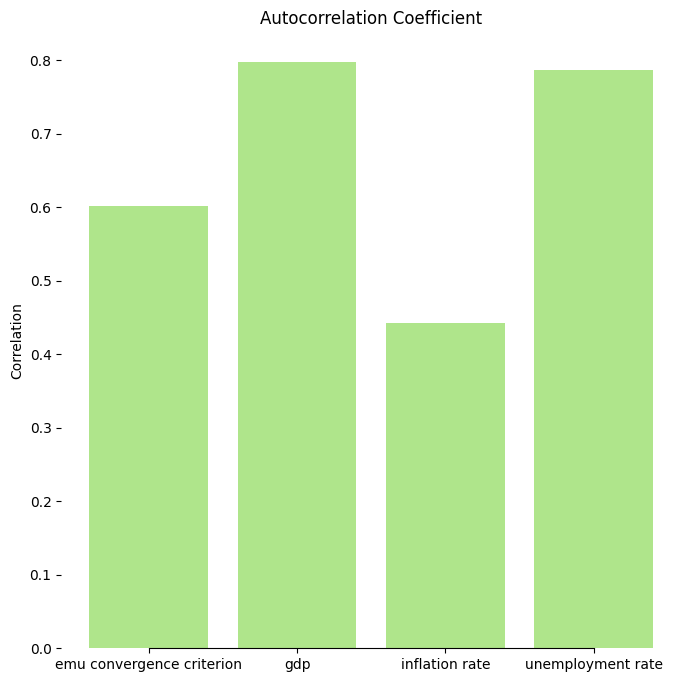

In [196]:
tick_locations = np.linspace(0, 3, len(df_state.columns))

fig, ax = plt.subplots(figsize=(8, 8))

plt.bar(np.arange(len(autocorr_val)), autocorr_val, color=COLORS[0], align='center', alpha=0.5)

ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(0, 3)

ax.set_title('Autocorrelation Coefficient')
ax.set_xticks(tick_locations, df_state.columns)
ax.set_ylabel('Correlation')

plt.show()

Coefficients are sufficient for forecasting purposes.

#### Forecasting

In [197]:
validation, forecast_viz = {}, {}

for col in df_state.columns:
    series = df_state[col]

    train_size = int(len(series) * 0.8)
    train, test = series[:train_size].to_list(), series[train_size:].to_list()

    model = Holt(train, initialization_method="estimated").fit()
    forecast = list(model.predict(start=0, end=len(train) + len(test) - 1))

    forecast_viz[col] = forecast
    validation[col] = forecast[-4:]

c:\Users\axel0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


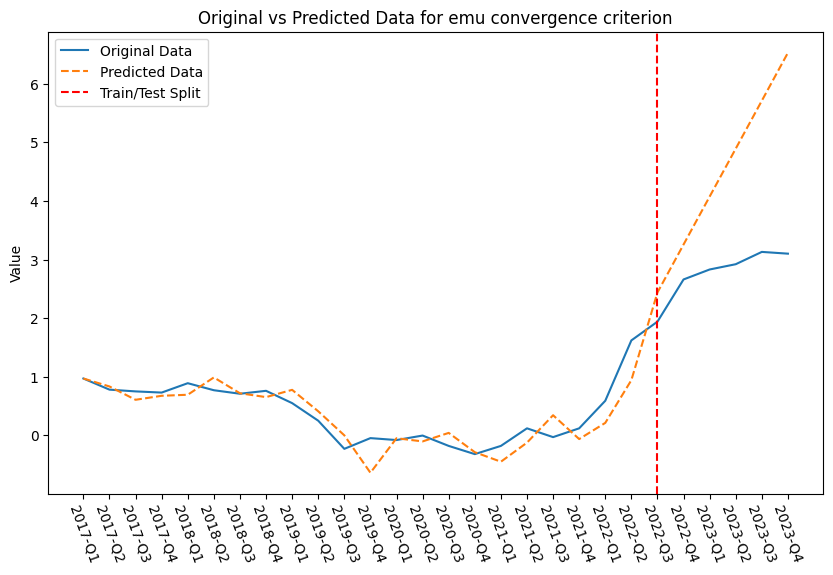

In [198]:
index = 'emu convergence criterion'

plt.figure(figsize=(10, 6))
plt.plot(df_state[index].index, df_state[index], label='Original Data')
plt.plot(df_state[index].index, forecast_viz[index], label='Predicted Data', linestyle='--')
plt.axvline(x=train_size, color='r', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title(f'Original vs Predicted Data for {index}')
plt.xticks(rotation=-70)
plt.ylabel('Value')
plt.show()

### Pearson's Correlation

In [199]:
norm_significant_var = StandardScaler().fit_transform(anova_behavior[significant_indexes])
pca_significant_var = PCA(n_components=2)
significant_var_component = pca_significant_var.fit_transform(norm_significant_var)

In [200]:
df_state['principal component'] = significant_var_component[:, 0]
df_state['secondary component'] = significant_var_component[:, 1]

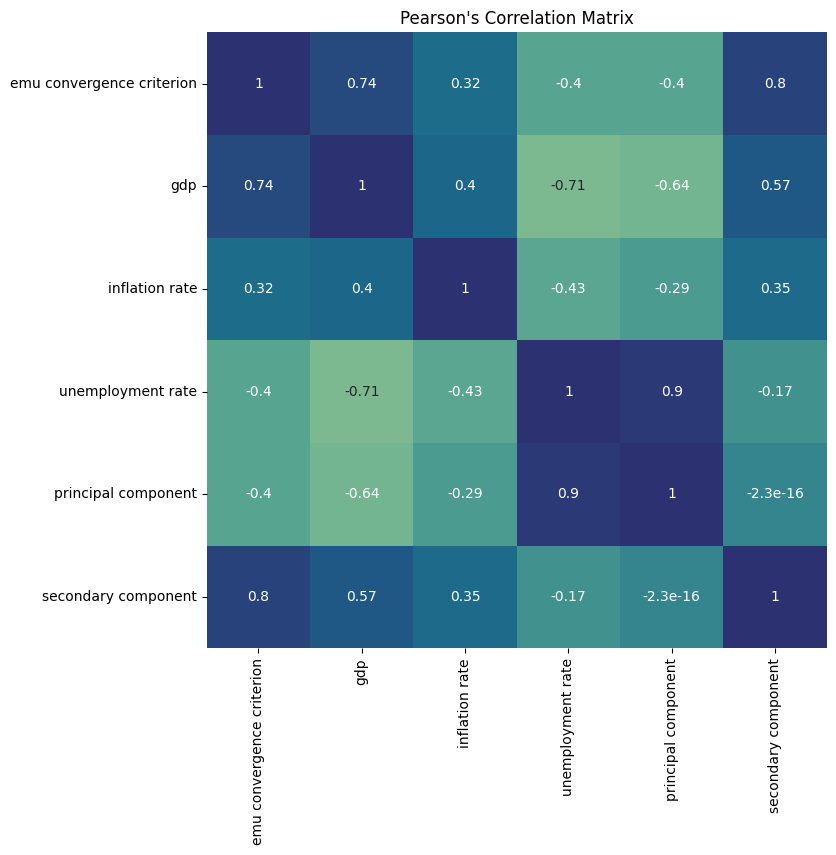

In [201]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_state.corr(), annot=True, cmap='crest', vmin=-1, vmax=1, cbar=False)
plt.title("Pearson's Correlation Matrix")
plt.show()

### Features Selection

Features Selection Process :

- Calculate Correlation Matrix
- Visualize the Correlation Matrix
- Identify Highly Correlated Features
- Remove One Feature from Each Pair of Highly Correlated Features
- Check Correlation with the Target Variable
- Select Features with High Correlation to Target
- Reomve Others

All explanatory variables are selected.

### Epsilon Correlation Coefficient

In [202]:
def ksaai(X, Y, ties=True):
    np.random.seed(42)
    n = len(X)
    order = np.array([i[0] for i in sorted(enumerate(X), key=lambda x: x[1])])
    if ties:
        l = np.array([sum(y >= Y[order]) for y in Y[order]])
        r = l.copy()
        for j in range(n):
            if sum([r[j] == r[i] for i in range(n)]) > 1:
                tie_index = np.array([r[j] == r[i] for i in range(n)])
                r[tie_index] = np.random.choice(r[tie_index] - np.arange(0, sum([r[j] == r[i] for i in range(n)])), sum(tie_index), replace=False)
        return 1 - n*sum( abs(r[1:] - r[:n-1]) ) / (2*sum(l*(n - l)))
    else:
        r = np.array([sum(y >= Y[order]) for y in Y[order]])
        return 1 - 3 * sum( abs(r[1:] - r[:n-1]) ) / (n**2 - 1)
    
def ksaai_corr_matrix(df, ties=True):
    columns = df.columns
    n = len(columns)
    corr_matrix = pd.DataFrame(np.zeros((n, n)), index=columns, columns=columns)
    
    for i in range(n):
        for j in range(i, n):
            if i == j:
                corr_matrix.iloc[i, j] = 1.0
            else:
                corr_value = ksaai(df.iloc[:, i], df.iloc[:, j], ties=ties)
                corr_matrix.iloc[i, j] = corr_value
                corr_matrix.iloc[j, i] = corr_value
    
    return corr_matrix

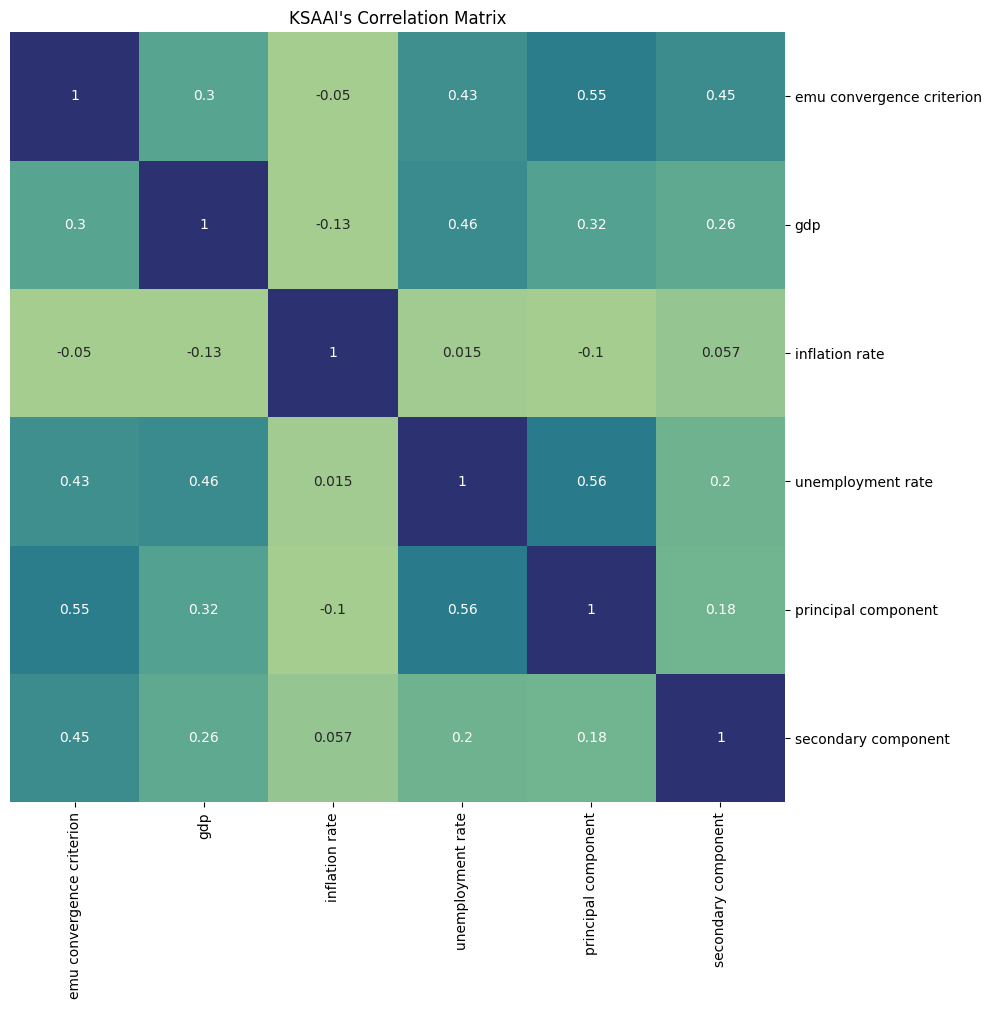

In [203]:
plt.figure(figsize=(10, 10))
sns.heatmap(ksaai_corr_matrix(df_state, True), annot=True, cmap='crest', vmin=0, vmax=1, cbar=False)
plt.tick_params(left=False, right=True, top=False, labelleft=False, labelright=True, labeltop=False, labelrotation=0)
plt.xticks(rotation=90)
plt.title("KSAAI's Correlation Matrix")
plt.show()

### Prediction

In [301]:
X = df_state.iloc[:, :-3]  # All rows, all columns except the last two (2 target variables)
y = df_state.iloc[:, -3:-1]  # All rows, last two columns (2 target variables)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [304]:
model = Sequential([
    Dense(64, input_dim=X.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(2)  # Output layer with 2 units (for 2 target variables)
])

model.compile(optimizer='adam', loss='mse')

In [305]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step - loss: 1.0244
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9735
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9249
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8778
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8321
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7881
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7473
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7087
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6724
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6380
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6053
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5747
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5464
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5203
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4961
Epoch 16/500
1/1 ━

In [306]:
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [313]:
df_state['cluster'] = df_per_household['cluster']
true_labels, true_index = [], []

for i in range(len(y_test)): 
    true_values = scaler_y.inverse_transform([y_test[i]])
    tolerance = 0.0001
    condition_x = (df_state['principal component'] >= true_values[0][0] - tolerance) & (df_state['principal component'] <= true_values[0][0] + tolerance)
    condition_y = (df_state['secondary component'] >= true_values[0][1] - tolerance) & (df_state['secondary component'] <= true_values[0][1] + tolerance)
    true_labels.append(int(df_state[condition_x & condition_y]['cluster']))
    true_index.append(str(df_state[condition_x & condition_y]['cluster'].index[0]))

### Classify KNN

In [314]:
data_points = []
for cluster in res:
    x_coords = res[cluster]['x']
    y_coords = res[cluster]['y']
    values = res[cluster]['values']
    for x, y, value in zip(x_coords, y_coords, values):
        data_points.append((cluster, [x, y], value))

In [315]:
pred_labels = []
for i in range(len(predictions)):
    pred_labels.append(knn_classification(data_points, list(predictions[i]), 5))

In [316]:
for i in range(len(predictions)):
    data_points.append((pred_labels[i], list(predictions[i]), true_index[i]))

### Visualize

In [317]:
pred_colors = [COLORS[i] for i in pred_labels]

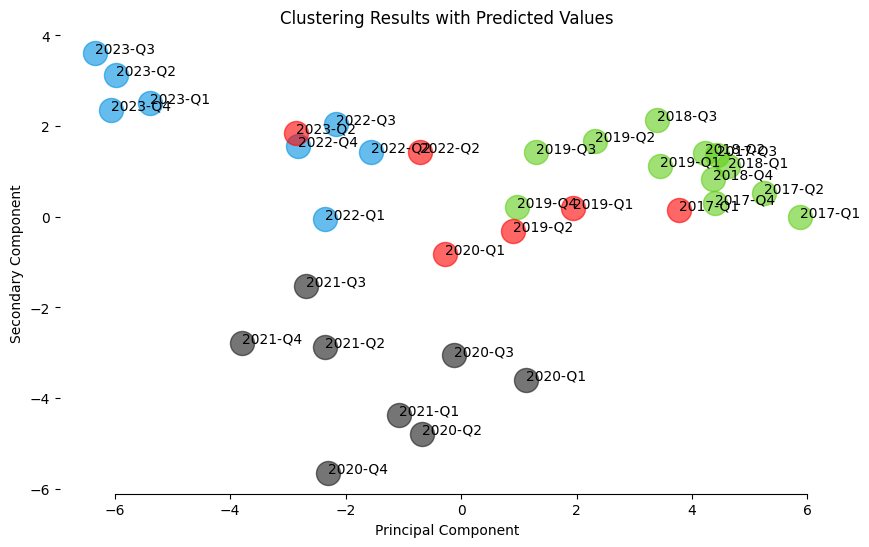

In [318]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Clustering Results with Predicted Values")
ax.set_xlabel("Principal Component")
ax.set_ylabel("Secondary Component")

for cluster in res:
    X, Y, labels = res[cluster]['x'], res[cluster]['y'], res[cluster]['values']
    ax.scatter(X, Y, c=COLORS[cluster], s=300, alpha=0.6)

ax.scatter(predictions[:, 0], predictions[:, 1], s=300, color='red', alpha=0.6)

for points in data_points:
        ax.annotate(points[2], points[1])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(-6, 6)

plt.show()